### Importar librerias

In [43]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import matplotlib
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor
from math import sqrt
import pmdarima as pm
import pickle

### Cargar el dataset

In [44]:
df = pd.read_csv(r"C:\Users\adria\Desktop\Carpeta pruebas Python\Proyecto_ML\data\processed\aemet_clear.csv")
df

,FECHA,TMEDIA
0,1920-01-01,11.0
1,1920-01-02,8.0
2,1920-01-03,8.0
3,1920-01-04,6.0
4,1920-01-05,5.0
...,...,...
37680,2023-03-01,5.0
37681,2023-03-02,6.0
37682,2023-03-03,7.0
37683,2023-03-04,8.0


### Un poco de información

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37685 entries, 0 to 37684
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FECHA   37685 non-null  object 
 1   TMEDIA  37685 non-null  float64
dtypes: float64(1), object(1)
memory usage: 589.0+ KB


### La columna "FECHA" convertirla en date_time e indexarla

In [46]:
df['FECHA'] = pd.to_datetime(df['FECHA'])
df = df.set_index('FECHA')

### Selecciono los datos hasta febrero de 2023 ya que el siguente mes esta incompleto y hago una media de temperatura por mes y lo entrno asi

In [47]:
df = df.loc[:'2023-02']
df = df.resample('M').mean()

### Un vistazo rápido de la temperatura ed todo el dataset

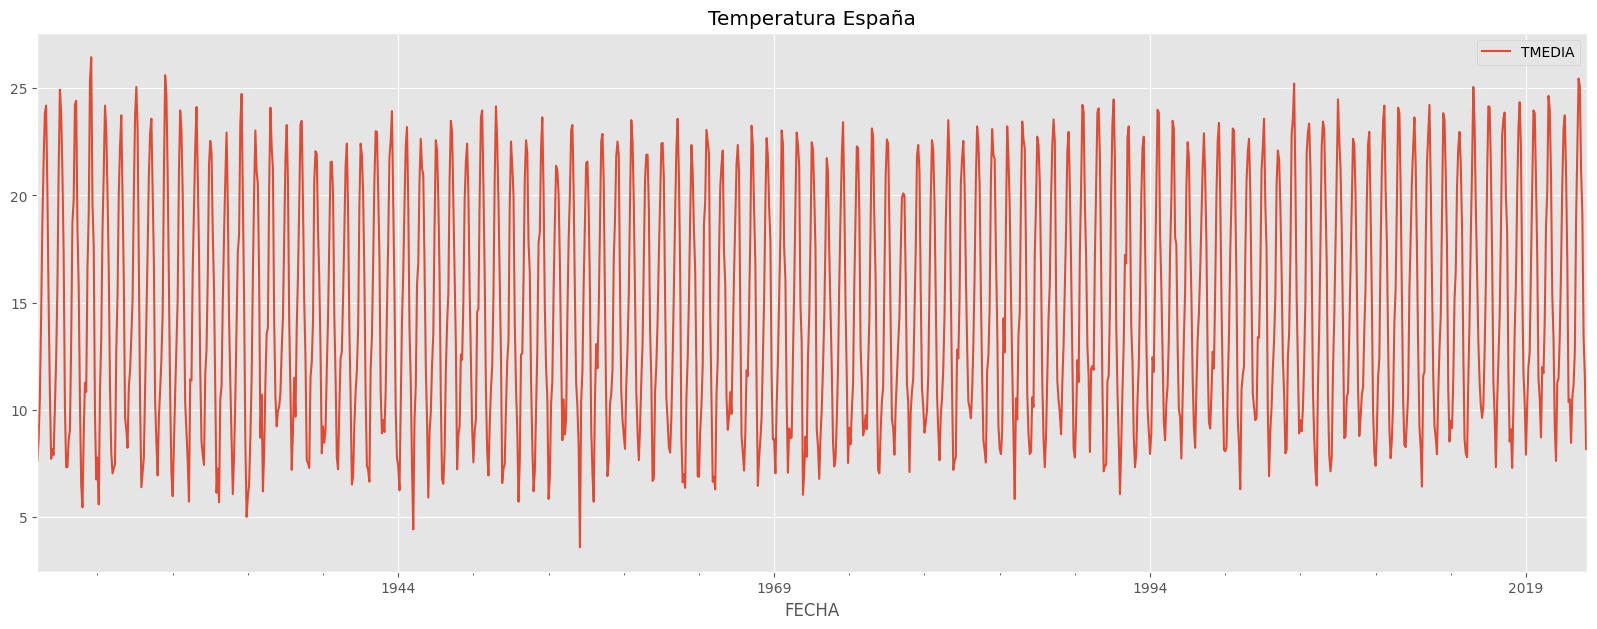

In [48]:
df.plot(figsize=(20,7))
plt.title('Temperatura España')
plt.show()

### Y ahora con la media anual

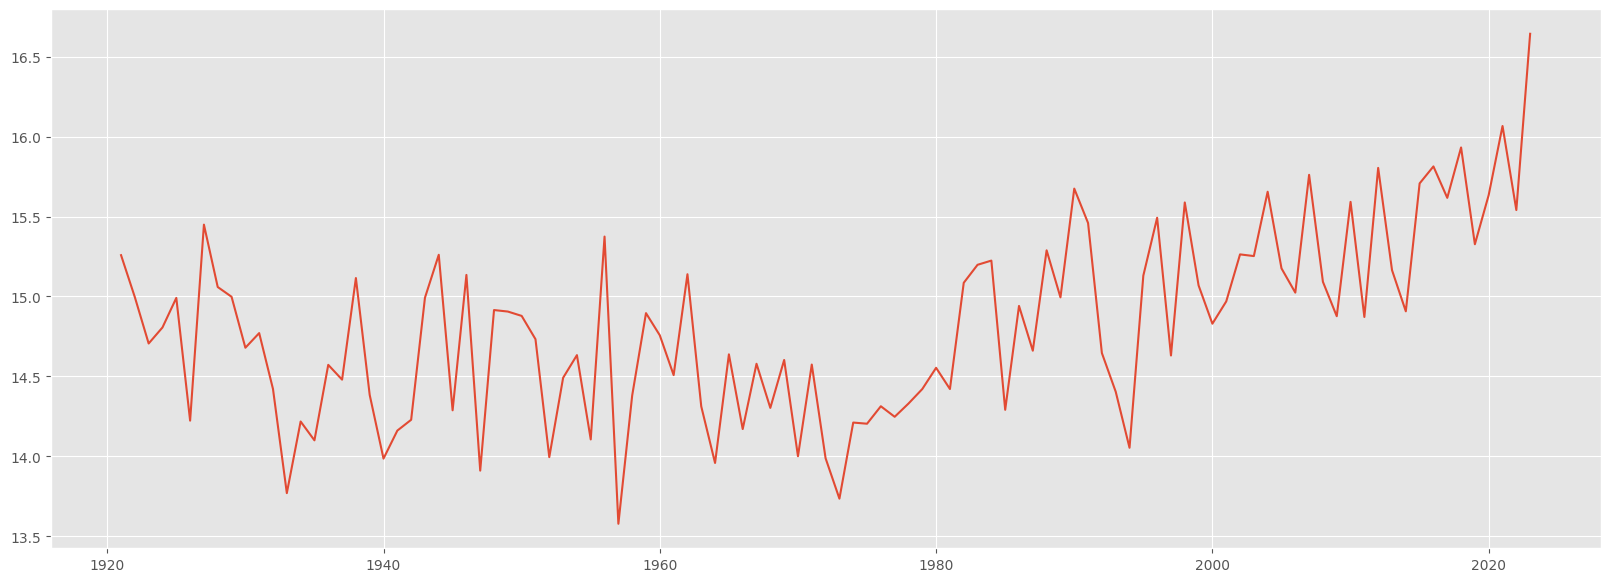

In [49]:
plt.figure(figsize=(20,7))
plt.plot(df.loc[:'2022'].resample('Y').mean());

### Distribución de los numeros

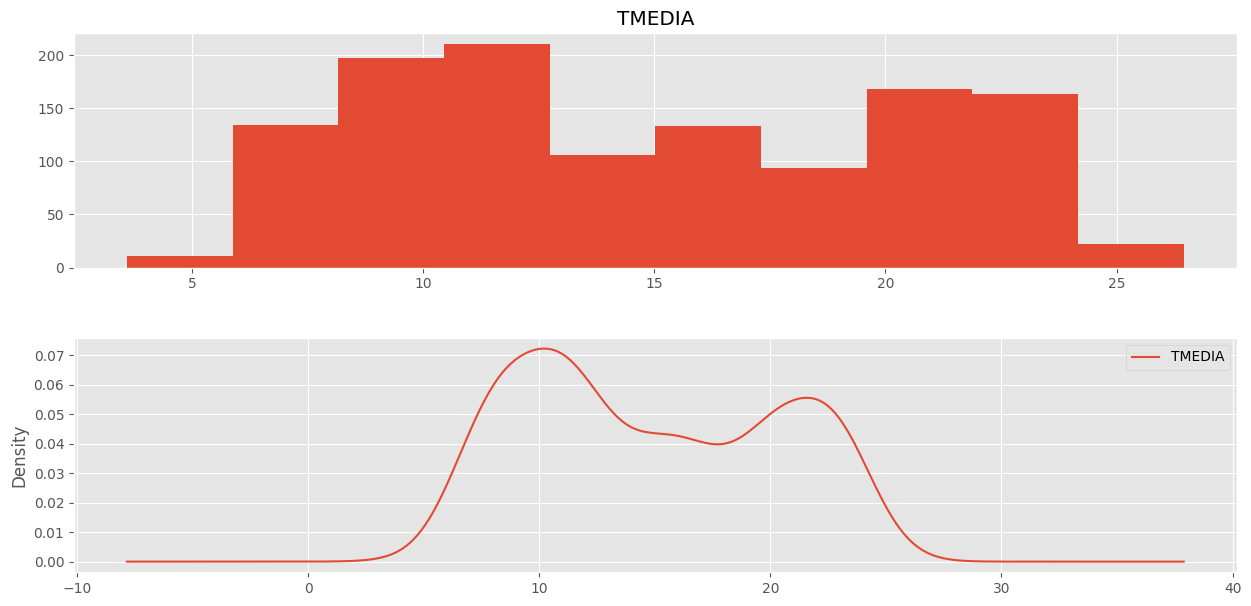

In [50]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False, figsize=(15,7))
df.hist(ax=ax1)
df.plot(kind='kde',ax=ax2)
plt.show()

### Descomponemos el dataset para verlo un poco mejor

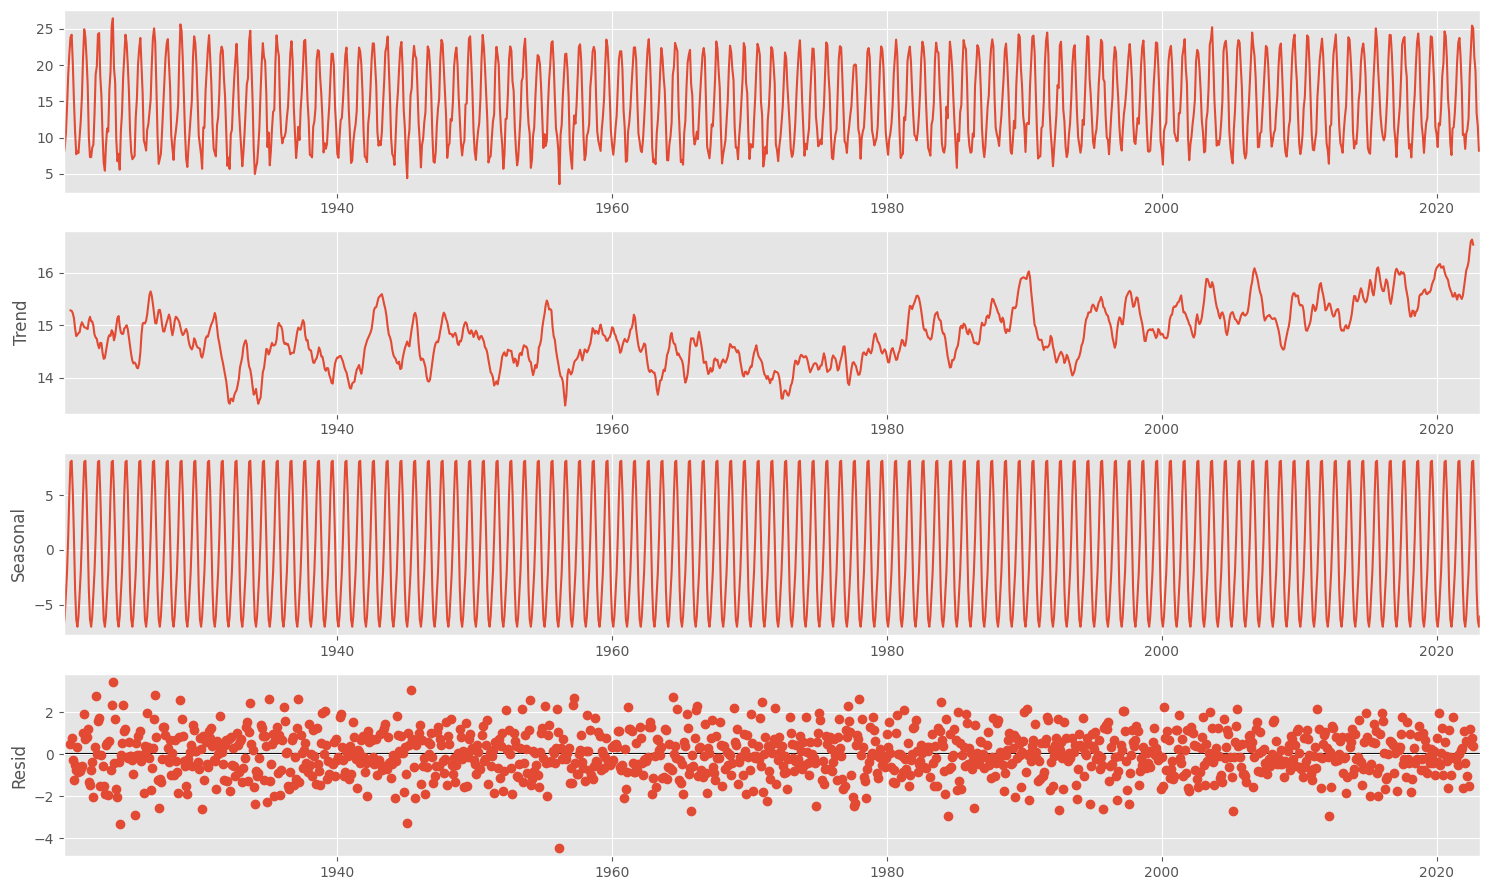

In [51]:
decomposition = seasonal_decompose(df,period=12, model='additive')
plt.rcParams['figure.figsize'] = 15, 9
decomposition.plot()
plt.show()

### La autocorrelación y correlación parcial

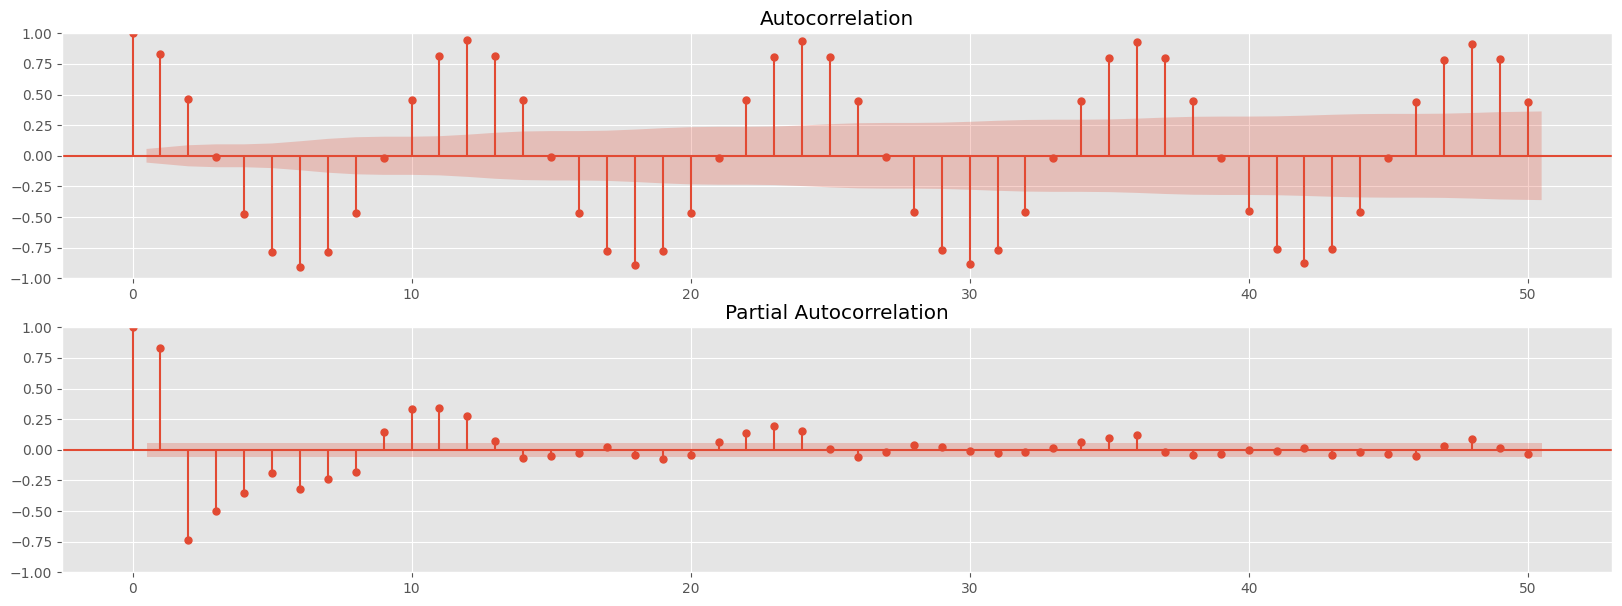

In [52]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20,7), sharex=False, sharey=False)
ax1 = plot_acf(df, lags=50, ax=ax1)
ax2 = plot_pacf(df, lags=50, ax=ax2)
plt.show()

### Pasar los datos por la prueba de Dickey-Fuller para ver el p-value, en este caso esta por muy poquito por encima de de 0.05

In [53]:
print ('Resultados del test Dickey-Fuller:')
dftest = adfuller(df)

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Resultados del test Dickey-Fuller:
Test Statistic                   -2.817234
p-value                           0.055854
#Lags Used                       23.000000
Number of Observations Used    1214.000000
Critical Value (1%)              -3.435748
Critical Value (5%)              -2.863924
Critical Value (10%)             -2.568039
dtype: float64


### Elegir el mejor modelo con autoarima

In [54]:
model = pm.auto_arima(df, d=1, D=1,
                      seasonal=True, m=12, trend='c', 
                      start_p=0, start_q=0, max_order=9, stepwise=True, trace=True, n_jobs=-1)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=1.13 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5157.521, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4564.124, Time=0.37 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.59 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=4930.800, Time=0.11 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=4406.278, Time=1.66 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=4.11 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.30 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=4642.257, Time=1.41 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=4297.138, Time=2.05 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=4456.892, Time=0.54 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=4.93 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.70 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=4274.271, Time=2.40 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=4435.6

### Pasar los resultados de "Best model:" de auto_arima a SARIMAX y entrenarlo

In [55]:
model1 = SARIMAX(df,order=(5,1,0),seasonal_order=(2,1,0,12))
results = model1.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                             TMEDIA   No. Observations:                 1238
Model:             SARIMAX(5, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -2085.065
Date:                            Fri, 24 Mar 2023   AIC                           4186.130
Time:                                    15:42:02   BIC                           4227.016
Sample:                                01-31-1920   HQIC                          4201.516
                                     - 02-28-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6532      0.027    -24.056      0.000      -0.706      -0.600
ar.L2         -0.4986      0.032    -15.608      0.000      -0.561      -0.436
ar.L3         -0.3436      0.033    -10.353      0.000      -0.409      -0.279
ar.L4         -0.3181      0.033     -9.564      0.000      -0.383      -0.253
ar.L5         -0.1455      0.029     -4.984      0.000      -0.203      -0.088
ar.S.L12      -0.6977      0.025    -27.971      0.000      -0.747      -0.649
ar.S.L24      -0.3523      0.027    -13.158      0.000      -0.405      -0.300
sigma2         1.7509      0.067     26.073      0.000       1.619       1.883
===================================================================================
Ljung-Box (L1) (Q):                   1.15   Jarque-Bera (JB):                 5.24
Prob(Q):                              0.28   Prob(JB):                         0.07
Heteroskedasticity (H):               0.76   Skew:                             0.07
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Pintar los resultados del modelo entrenado

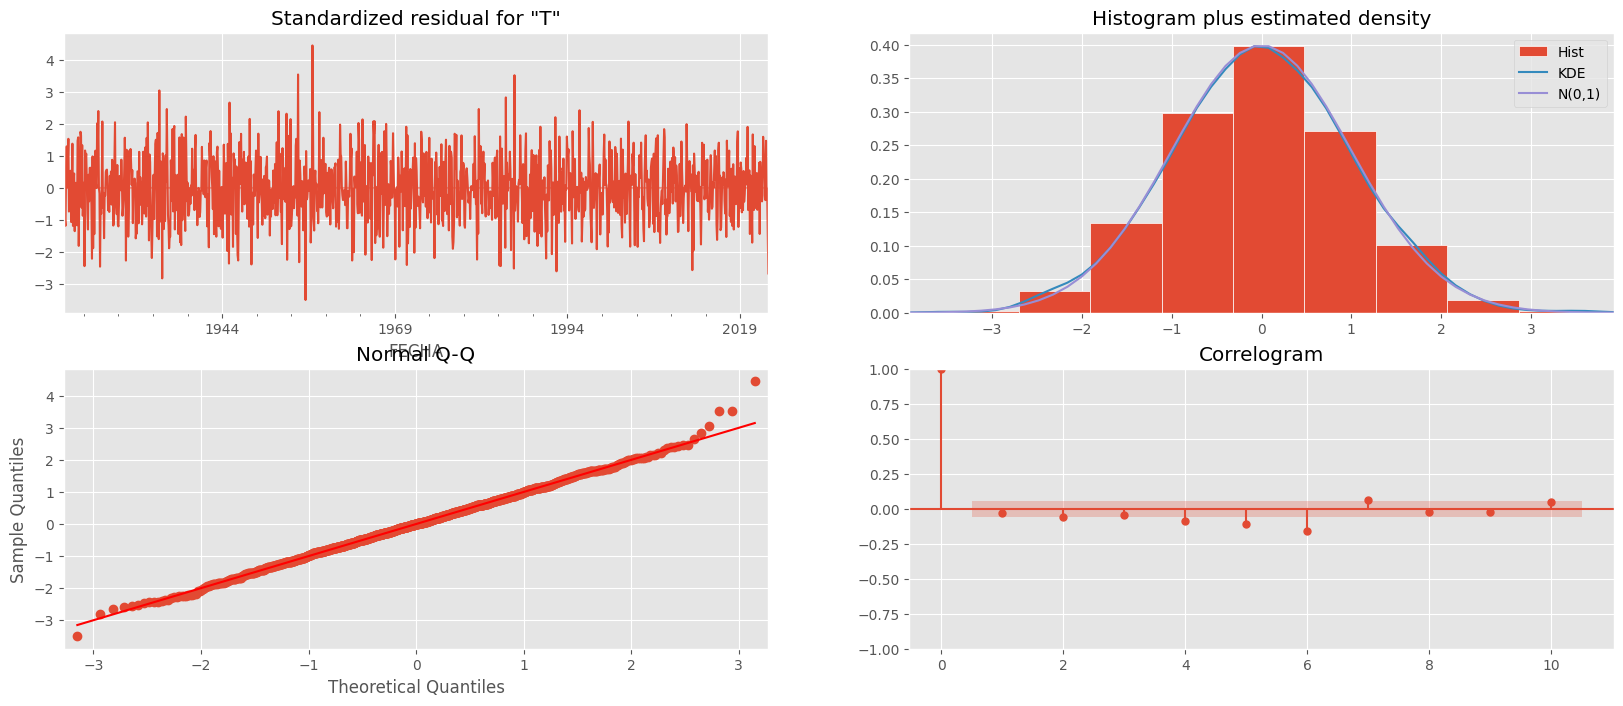

In [56]:
results.plot_diagnostics(figsize=(20, 8))
plt.show()

### Ver los resultados de la temperatura real vs la prediccion del modelo

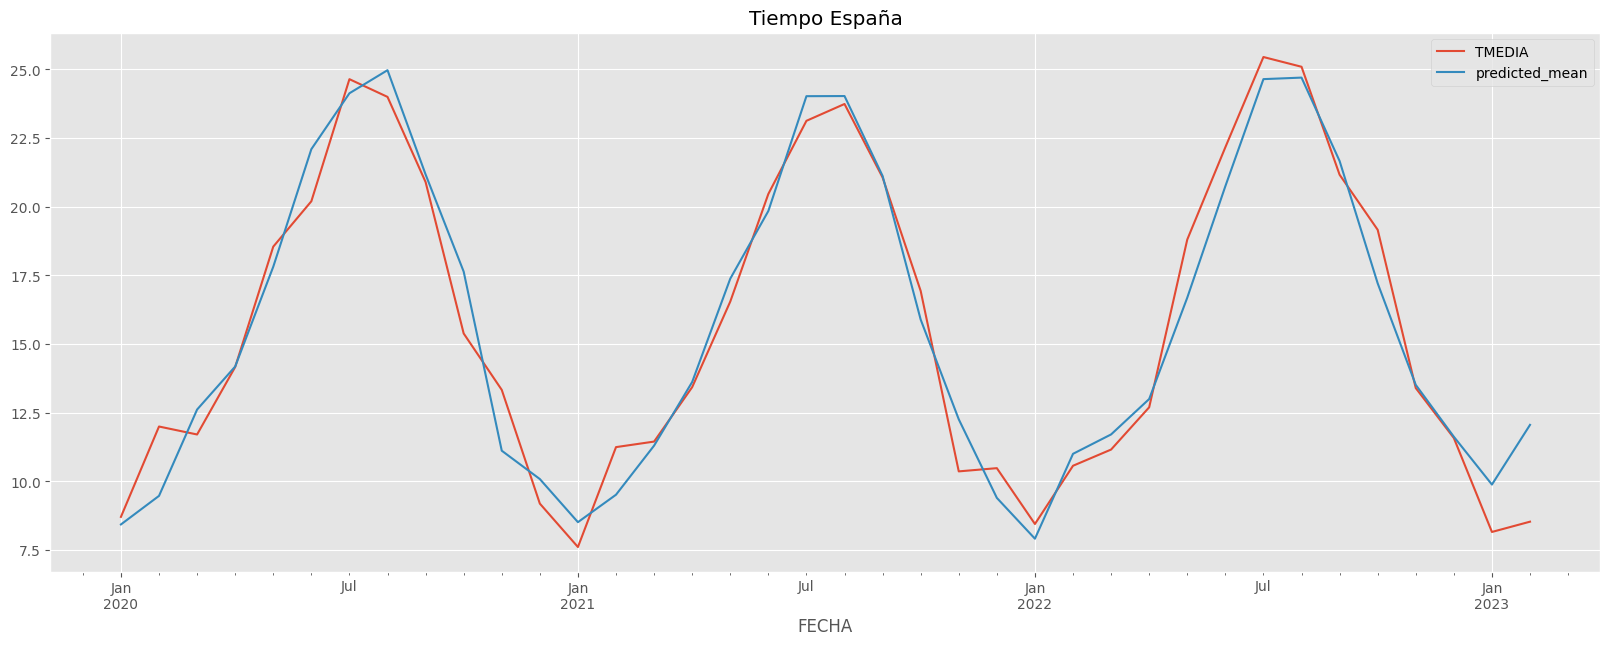

In [57]:
predictions = results.predict(start=0, end=len(df)-1)
title = 'Tiempo España'
ax = df.loc['2020':].plot(legend=True,figsize=(20,7),title=title)
predictions.loc['2020':].plot(legend=True)
ax.autoscale()

### Y ahora la prediccion para dos años, recordar que la temperatura esta en media mensual

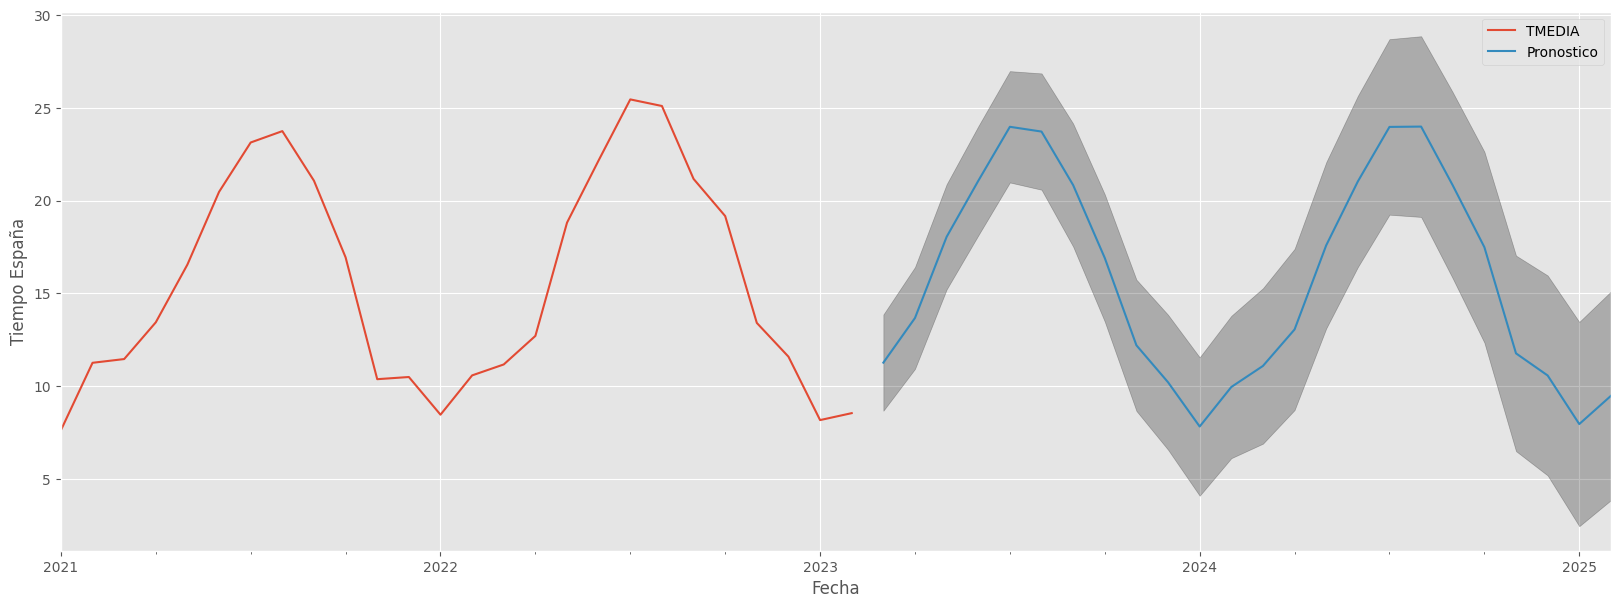

In [58]:
pred_f = results.get_forecast(steps=24)
pred_ci = pred_f.conf_int()
ax = df.loc['2021':].plot(label='Real', figsize=(20, 7))
pred_f.predicted_mean.plot(ax=ax, label='Pronostico')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Fecha')
ax.set_ylabel('Tiempo España')
plt.legend()
plt.show()

### Veamos los errores en en numeros

In [59]:
print('r2_score: (%s)'%r2_score(pred_f.predicted_mean,df[-24:].values))
print('MSE (%s)'%mean_squared_error(pred_f.predicted_mean,df[-24:].values))
print('RMSE (%s)'%sqrt(mean_squared_error(pred_f.predicted_mean,df[-24:].values)))

r2_score: (0.9701876924504337)
MSE (0.899191938622624)
RMSE (0.9482573166723387)


#### Guardamos el modelo entrenado

In [62]:
#with open(r"C:\Users\adria\Desktop\Carpeta pruebas Python\Proyecto_ML\model\SARIMAX_2.pickle", "wb") as f:pickle.dump(results, f)

#### Con este comando leemos el archivo guardado anteriormente

In [ ]:
#with open(r"C:\Users\adria\Desktop\Mi primer proyecto\Proyecto_ML\model\results.pickle", "rb") as f:results_pick = pickle.load(f)
#print(results_pick)